# An explanation of XGA's hierarchical clustering peak finder

This notebook doesn't really explain how to use this new peak finder, it is generally called automatically, but it does explain how it works, as well as how it is employed in XGA.

In [1]:
from astropy.units import Quantity, pix
from matplotlib import pyplot as plt
import numpy as np
from astropy.visualization import LogStretch, MinMaxInterval, ImageNormalize

from xga.sources import GalaxyCluster

## Why find X-ray peaks?

For Galaxy Cluster analysis, it is often difficult to define the 'centre' of a given cluster. There are various different measures used by different analysis teams, which of course vary between the observation wavelength; in optical observations, for instance, the brightest cluster galaxy is often used as a measure of the centre. 

X-ray astronomers have a distinct advantage here, as the photons we observe trace the actual intra-cluster medium, and so we are in effect tracing the potential well of the halo. As such, the X-ray peak of the cluster is considered a good proxy for the centre (see [Yan et al.](https://arxiv.org/ct?url=https%3A%2F%2Fdx.doi.org%2F10.1093%2Fmnras%2Fstaa295&v=a899512c) for a comparison of various measures of the centre of cluster using hydrodynamical simulations), and has been used to 'correct' miscentering biases encountered when stacking weak lensing profiles in the DES Y1 cluster cosmology analysis ([Zhang et al.](https://arxiv.org/ct?url=https%3A%2F%2Fdx.doi.org%2F10.1093%2Fmnras%2Fstz1361&v=4dfe0ea6)).

Once we know the location of the centre of the cluster, we can centre our analysis regions on it; this is especially important for making radial profiles.

## Motivation for a new peak finding method

To correct for the spatial variation of exposure times across the XMM field of view (caused primarily by vignetting), peak finding methods should be performed on a 'ratemap', created by dividing an image by an exposure map. Unfortunately, the calculation of exposure maps seems to become difficult near the edges of CCDs, and can the exposure values can be artificially reduced - this in turn can create artificially bright pixels in the ratemap.

If one of those boosted pixel values happens to be in the region we're searching for a cluster centre, then it is possible that it will be selected over the true centre. Not only that, but if point sources are not properly removed it is possible that the brightest pixel in a given region could be in the remnants of the point source emission.

It is possible to apply a smoothing kernel to alleviate some of these problems, but I wanted to try another approach that didn't decrease the spatial resolution, and doesn't need to be checked by eye after the fact.

## I'll start this demo by declaring a Galaxy Cluster object

The procedure explained in this notebook is automatically performed on the combined RateMap data when an ExtendedSource or GalaxyCluster object is declared. By default, 0.5-2.0keV ratemaps are used, but the user can override this when initialising the source object. This method is also used to find peaks for the individual ratemaps as well, but the combined peak is the main result used by XGA.

Unlike the ratemaps used in these demos, the peak finding algorithm built into ExtendedSource and GalaxyCluster classes places masks its ratemaps with a search aperture, as well as removing point sources. I'm writing the demonstration this way to demonstrate the power of the new method.

In [2]:
# Not the real r500 of this cluster, just an arbitrary radius
r500 = Quantity(1200, 'kpc')

# Abell 907, my favourite Galaxy Cluster!
source = GalaxyCluster(149.5904478, -11.0628750, redshift=0.16, name="A907", r500=r500, load_products=True, 
                       load_fits=True)

# So here we can see the final result of the procedure explained in this notebook - the hierarchical peak of the
#  combined 0.5-2.0keV ratemap
print(source.peak)

# You can also access the final point clusters output by the algorithm, the first tuple entry being the source,
#  and the second being a list of all other clusters.
a907_source_point_cluster, a907_other_point_clusters = source.point_clusters
# I know this means nothing to you right now, but it will in a second.

/home/dt237/code/PycharmProjects/XGA/xga/products.py:304: UserWarning: You are loading an ratemap with elements that are < 0, they will be set to 0.
  warnings.warn("You are loading an {} with elements that are < 0, "
/home/dt237/code/PycharmProjects/XGA/xga/products.py:304: UserWarning: You are loading an image with elements that are < 0, they will be set to 0.
  warnings.warn("You are loading an {} with elements that are < 0, "


[149.59251341 -11.06395832] deg


## A quick reminder of XGA RateMaps and masks

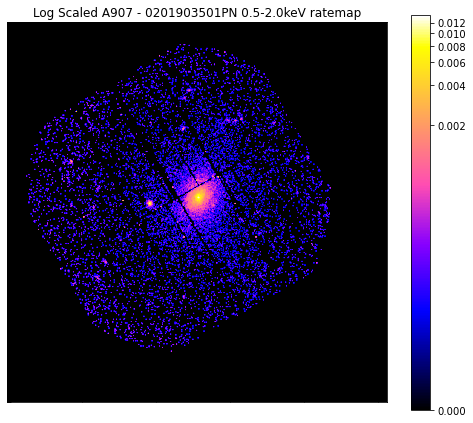

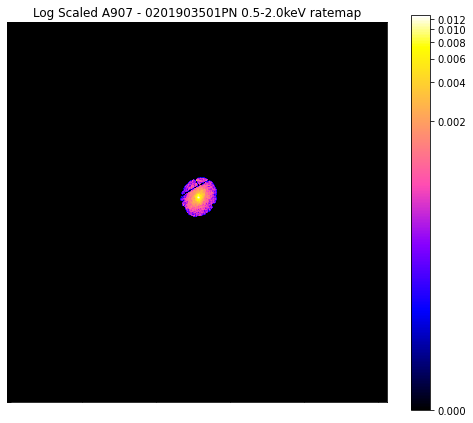

In [3]:
# You can quickly grab a particular ratemap object from a source using the get_products method
# In this case get_products will return a list of all PN 0.5-2.0keV ratemaps, because I didn't specificy an ObsID
# I just take the last one, it doesn't really matter for this demonstration.
pn_ratemap = source.get_products("ratemap", inst="pn", extra_key="bound_0.5-2.0")[-1]

# Can have a quick look at the ratemap
pn_ratemap.view()

# I can also get the mask that XGA has created for this observation from region files 
pn_mask = source.get_mask("region", pn_ratemap.obs_id, "pn")[0]
# And make an array of ones to act as a 'flat mask' where nothing is excluded
flat_mask = np.ones(pn_mask.shape)

# And of course we can look at the image with the region mask applied
pn_ratemap.view(mask=pn_mask)

The first image in the cell above perfectly demonstrates my point about artificially brightened ratemap pixel values. You can see them dotted all over the observation on the edges of PN's many chips. We have to come up with a way to deal with them and remove them from consideration.

## The simplest possible peak finding

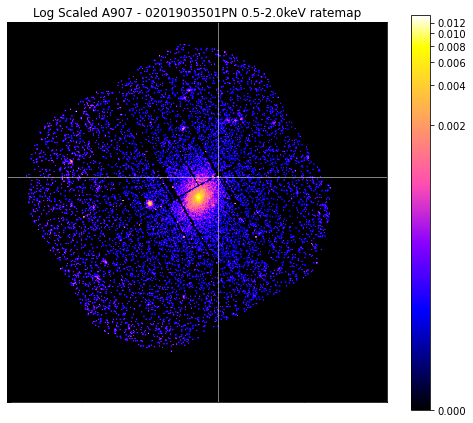

In [4]:
# This is an efficient numpy way to find the coordinates of the maximum value point in an array, 
#  the simplest thing we could possibly do.
peak = np.unravel_index(np.argmax(pn_ratemap.data), pn_ratemap.shape)

# peak[1] goes into the Quantity first because numpy uses row, column ordering, whereas people expect
#  pixel coordinates in column, row ordering.
pn_simple_pix_peak = Quantity([peak[1], peak[0]], pix)

# This plots crosshairs for the maximum value pixel on the ratemap, we can see it's one of the 
#  pixels that looks artificially brightened.
pn_ratemap.view(pn_simple_pix_peak)

## A solution to the edge problem

I decided that I would exclude all pixels that sat on the edge of a chip from being peak candidates. As such I needed a way to choose which pixels where on an edge and which weren't. I repurposed a method of mapping XMM detectors from another piece of work I've done, and used an edge finding algorithm on an exposure map where every value that wasn't 0 was set to 1.

All that happens then is that the array is differentiated in X and Y directions, then the two resultant arrays are added together. As such an edgemap pixel $e_{i,j}$ is

$$e_{i,j} = (p_{i,j} - p_{i+1,j}) + (p_{i,j} - p_{i,j+1})$$

where $p_{i, j}$ is the pixel value of the modified exposure map at coordinates $i, j$.


This makes it easy to know when you're going from 'not on a chip' to 'on a chip' and vice versa; $e_{i,j}$ is -1 when moving from 'not on a chip' to 'on a chip', and 1 when moving from 'on a chip' to 'not on a chip'. The modified exposure map is differentiated in both X and Y directions to make sure we capture all the edges, but some will be detected in both directions, so when the arrays are added together there could be edge map pixels with a value of 2, which generally means they are a corner of a chip.

As we wish to know where the edges are, any values of -1 are shifted over by 1, then set to 1, in the direction of the differentiation they belong to. The array is then inverted, so everywhere _but_ the edges is 1.

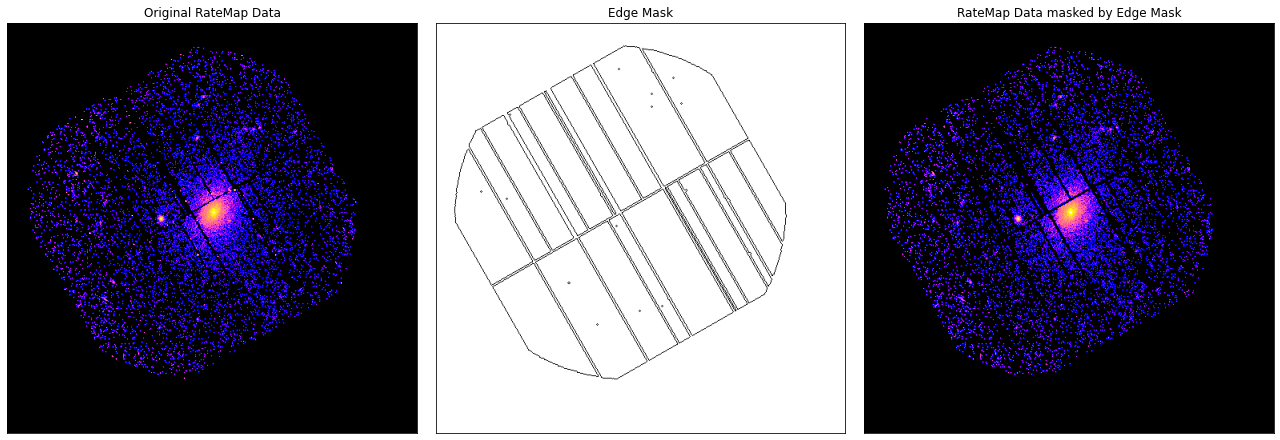

In [5]:
# We can quickly plot an edge mask, and the difference it makes when applied to an image.
fig, ax_arr = plt.subplots(ncols=3, nrows=1, figsize=(18, 6), sharey='row',)

for ax in ax_arr: 
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

norm = ImageNormalize(pn_ratemap.data, interval=MinMaxInterval(), stretch=LogStretch())
# Original ratemap goes in the left plot
ax_arr[0].imshow(pn_ratemap.data, norm=norm, origin="lower", cmap="gnuplot2")
ax_arr[0].set_title('Original RateMap Data')
# The edgemask goes in the middle
ax_arr[1].imshow(pn_ratemap._edge_mask, origin="lower", cmap="gray")
ax_arr[1].set_title('Edge Mask')
# And finally, the ratemap with edgemask applied goes on the right.
norm = ImageNormalize(pn_ratemap.data*pn_ratemap._edge_mask, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[2].imshow(pn_ratemap.data*pn_ratemap._edge_mask, norm=norm, origin="lower", cmap="gnuplot2")
ax_arr[2].set_title('RateMap Data masked by Edge Mask')

fig.tight_layout()

plt.show()

## New Peak Finding Method

Finally, to (hopefully) account for any point source remnants in the RateMap, I've introduced a new method that uses the hierarchical clustering algorithm to choose the pixels most likely to belong to the cluster we're searching for.

**This method is not going to work well/at all for point sources, though I will try and address that in future work.**

Again you must bear in mind that by this point the data is usually masked to remove point sources, and to place an aperture down in which we search for a peak. I'm not doing that in this case because it makes it easier to show you what the new method does, and also demonstrates how well it performs even under the worst conditions.

### Demonstrating the downside of the simple peak method

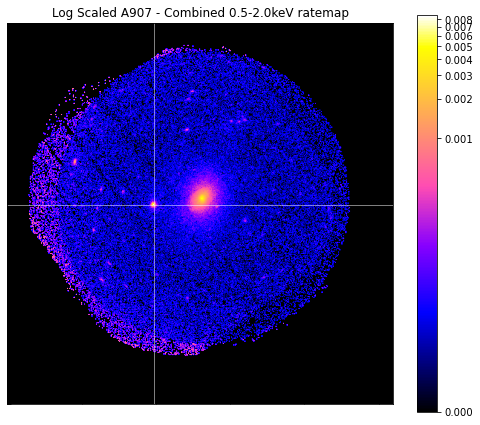

In [6]:
# Getting the combined ratemap, demonstrating on the combined data because that's where XGA gets the peak
#  value it uses.
combined_ratemap = source.get_products('combined_ratemap')[0]
# The peak finding methods of a RateMap require a numpy mask, but for the demonstration I don't want to 
#  mask the data, so I construct a numpy array of ones to act as a flat mask
combined_flat_mask = np.ones(combined_ratemap.shape)

# So then can use the simple peak finding method where this edge mask is automatically applied
#  This method just finds the brightest pixel, after the edge mask has been applied
simple_peak, near_edge = combined_ratemap.simple_peak(combined_flat_mask)
# Then we can view the combined data with the crosshair at the 'simple peak'
combined_ratemap.view(simple_peak, combined_ratemap._edge_mask)

So now that we've removed the edge map, and once again searched for the brightest pixel, we find that we're still not getting a good answer. We've selected a bright point source instead. Now, hopefully in real use whatever source finder you've used would have found, and produced a region for, a powerful source like that - but the same thing could happen with a particularly bright point source remnant.

### What is hierarchical clustering and how does help?

It is a clever little algorithm that can be used to cluster data points in some arbitrary feature space until some completion criteria has been met. In this case we are clustering on X and Y spatial coordinates, so intuitively it is quite easy to understand, but the algorithm can cluster any kind of information.

It starts off by assuming that each point is a separate cluster, then repeatedly identifies the clusters that are closest together and combines them. I use the scipy fclusterdata function, with an inconsistency threshold of 1.

I take the spatial coordinates of the pixels with the top 5% (by default) of values in the ratemap, then run this hierarchical clustering algorithm on them. Once it's complete I find the largest cluster of points that was generated, and assume that this is the galaxy cluster I'm looking for. This excludes any small patches of emission that might be left over from point sources, and so I then just find the pixel with the maximum value in the chosen point cluster.

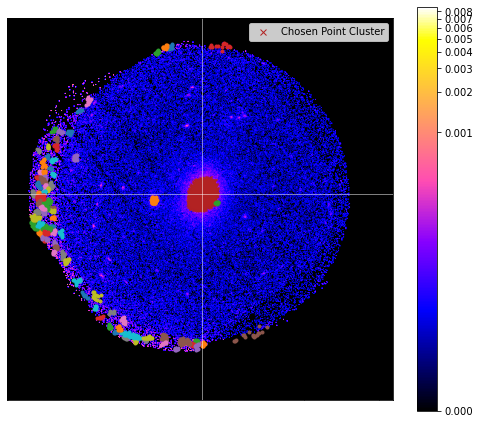

In [9]:
# I run my clustering peak finder on the combined ratemap, with no mask, and outputting the peak 
#  coordinates in pixels
# Returns the peak coordinates, a boolean flag that says whether the peak is near an edge, 
#  the chosen point cluster, and a list of all the other point clusters found (quite a few 
#  because there is no mask applied).
comb_pix_peak, near_edge, src, others = combined_ratemap.clustering_peak(combined_flat_mask, pix)

# Just sets up and plots the combined ratemap and all the point clusters
plt.figure(figsize=(7, 6))
ax = plt.gca()
ax.tick_params(axis='both', direction='in', which='both', top=False, right=False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
norm = ImageNormalize(combined_ratemap.data * combined_ratemap._edge_mask, interval=MinMaxInterval(), 
                      stretch=LogStretch())
plt.imshow(combined_ratemap.data * combined_ratemap._edge_mask, norm=norm, origin="lower", cmap="gnuplot2")
plt.colorbar()
plt.plot(src[:, 0], src[:, 1], 'x', label="Chosen Point Cluster", color='firebrick')

for bad_ind, bad in enumerate(others):
    # Only plotting other point clusters with more than 6 points purely to make the image a 
    #  little nicer to look at.
    if bad.shape[0] > 6:
        plt.plot(bad[:, 0], bad[:, 1], '.')
    
plt.axhline(comb_pix_peak[1].value, color="white", linewidth=0.5)
plt.axvline(comb_pix_peak[0].value, color="white", linewidth=0.5)
plt.legend(loc="best")
plt.tight_layout()

plt.show()

So here we can see that even though I left all of the point sources still in, the algorithm has still successfully realised where the galaxy cluster in the image is. It's made point clusters out of the point source to the left, as well as the one on the bottom right of the cluster, but it has still made the correct choice.

The implementation of this process in the ExtendedSource and GalaxyCluster classes is actually iterative. Firstly, an aperture with a radius of 500kpc (or 5 arcminutes) is placed at the user supplied source coordinates, with interloper sources being masked out. The radius is only set to 5 arcminutes if the user has defined an extended source with no redshift information (which is allowed), if the source is a GalaxyCluster object, redshift information is required so it will always use 500kpc.

Then the algorithm follows these steps (for upto 20 iterations before it throws an error):
1. Runs the hierarchical peak finder.
2. Re-centres the search aperture at the new coordinates.
3. Checks to see if the new peak is within 15kpc (or 0.15 arcminutes) of the last central coordinate.
4. If it is, consider the peak converged and exit, if it isn't (or if the algorithm is on the first iteration), go back to 1.

Initially run on the combined ratemap, then on the individual ratemaps of the different observations/instruments. If the combined ratemap peak won't converge, a hard error will be thrown (as this is what XGA analyses uses as the centre), the individual peaks are allowed to not converge.

The user can also choose to use their initial coordinates as the cluster centre, if they don't want to find and use the peak.